In [232]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
import os
import sys
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

sys.path.append("../")

In [234]:
import lusim as sim
import network as nn
import project_utilities as utils
from draw_neural_net import draw_neural_net, draw_weighted_neural_net, get_rgb
from nscore import NormalScoreTransformer
from objective_cls import Objective
from pde import pde
from variogrammodel import VariogramModel

In [235]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [236]:
rng = np.random.default_rng(seed=6875)

# Load Drillholes

In [237]:
comps = pd.read_csv("ccg_dh.csv")
comps = comps.loc[comps["Au"].notna()]
dhid = "dh"
dhids = comps[dhid].values
comps.head()

,dh,from,to,x,y,z,Au,Cu,Au:shell,Cu:shell,wts,NS_Au,NS_Cu
0,1,0.0,10.0,19975.1709,18698.0376,210.0856,0.0601,50.0000,0,0,0.040878,-0.747376,-0.438787
1,1,10.0,20.0,19978.1547,18702.6831,201.7479,0.0700,33.0000,0,0,0.030318,-0.693788,-1.308371
2,1,20.0,30.0,19981.1466,18707.3233,193.4103,0.7600,97.0001,0,0,0.023614,0.986044,0.469923
3,1,30.0,40.0,19984.1556,18711.9612,185.0775,0.2800,66.0000,0,0,0.018470,0.172976,-0.119258
4,1,40.0,50.0,19987.1566,18716.5869,176.7350,0.3700,58.0000,0,0,0.017237,0.346840,-0.259291


In [238]:
len(comps)

746

In [239]:
dh_lens = []
for uid in comps[dhid].unique():
    dh_lens.append(len(comps.loc[comps[dhid] == uid]))
maxdhlen = max(dh_lens)
ndh = len(dh_lens)
print(ndh, maxdhlen)

64 19


(19774.712153369175, 20204.809646630823, 18486.43567339956, 19053.798726600442)

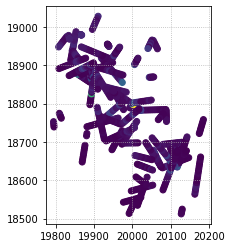

In [240]:
plt.scatter(comps["x"], comps["y"], c=comps["Au"])
plt.axis("scaled")

(19774.712153369175, 20204.809646630823, 100.2587333995585, 282.6776666004414)

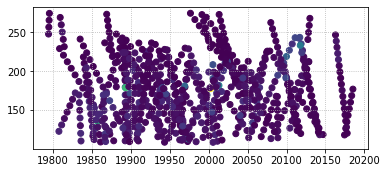

In [241]:
plt.scatter(comps["x"], comps["z"], c=comps["Au"])
plt.axis("scaled")

In [242]:
# grid definition
grid = utils.from_pickle("ccg_griddef.pkl")
griddef = {
    "nx": 41,
    "ny": 54,
    "nz": 18,
    "xsize": 10,
    "ysize": 10,
    "zsize": 10,
    "xmin": 19794.271,
    "ymin": 18512.2387,
    "zmin": 108.5643,
}
print(grid)

41 19794.271 10.0 -nx, xcmin, xsize
54 18512.2387 10.0 -ny, ycmin, ysize
18 108.5643 10.0 -nz, zcmin, zsize


In [243]:
gridstr = """41 19794.271 10.0 -nx, xcmin, xsize
54 18512.2387 10.0 -ny, ycmin, ysize
18 108.5643 10.0 -nz, zcmin, zsize"""

# Continuous Variograms

- calculate experimental NS variograms

In [244]:
from variogram_objective import update_variogram, variogram_pairs

azm = [-40, 50, 0]
atol = [30, 30, 30]
bandh = [999]
dip = [0, 0, -90]
dtol = [30, 30, 30]
bandv = [999]
nlags = [8, 8, 8]
lagdis = [30, 20, 20]
lagtol = [17, 12, 12]

maj_lag_dict, maj_bins = variogram_pairs(
    comps,
    "x",
    "y",
    "z",
    azm[0],
    atol[0],
    bandh[0],
    dip[0],
    dtol[0],
    bandv[0],
    nlags[0],
    lagdis[0],
    lagtol[0],
)

min_lag_dict, min_bins = variogram_pairs(
    comps,
    "x",
    "y",
    "z",
    azm[1],
    atol[1],
    bandh[0],
    dip[1],
    dtol[1],
    bandv[0],
    nlags[1],
    lagdis[1],
    lagtol[1],
)

vrt_lag_dict, vrt_bins = variogram_pairs(
    comps,
    "x",
    "y",
    "z",
    azm[2],
    atol[1],
    bandh[0],
    dip[2],
    dtol[1],
    bandv[0],
    nlags[2],
    lagdis[2],
    lagtol[2],
)

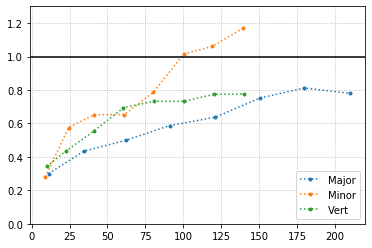

In [245]:
maj_vario = update_variogram(comps["NS_Au"].values, maj_lag_dict)
min_vario = update_variogram(comps["NS_Au"].values, min_lag_dict)
vrt_vario = update_variogram(comps["NS_Au"].values, vrt_lag_dict)

fig, ax = plt.subplots()
ax.plot(maj_bins, maj_vario, ls=":", marker=".", label="Major")
ax.plot(min_bins, min_vario, ls=":", marker=".", label="Minor")
ax.plot(vrt_bins, vrt_vario, ls=":", marker=".", label="Vert")
ax.set_ylim(0, 1.3)
ax.axhline(1.0, c="k")
ax.legend(loc=4)

- fit with a model to use as an optimization target

In [246]:
vstr = """3    0.1                         -nst, nugget effect
    2    0.2  -40.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    50.0  100.0  50.0        -a_hmax, a_hmin, a_vert
    2    0.3  -40.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    175.0  125.0  175.0        -a_hmax, a_hmin, a_vert
    2    0.4  -40.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    1500.0  125.0  350.0        -a_hmax, a_hmin, a_vert"""

vario = VariogramModel(vstr)
target_maj = vario.calcpoints(azm[0], dip[0], lagdist=1, nlags=300)["Variogram"]
target_min = vario.calcpoints(azm[1], dip[1], lagdist=1, nlags=300)["Variogram"]
target_vrt = vario.calcpoints(azm[2], dip[2], lagdist=1, nlags=300)["Variogram"]

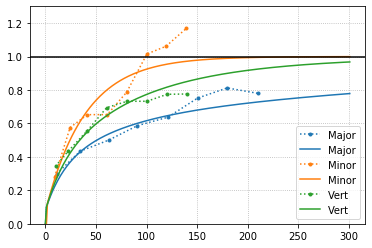

In [247]:
fig, ax = plt.subplots()
ax.plot(maj_bins, maj_vario, ls=":", marker=".", c="C0", label="Major")
ax.plot(target_maj, label="Major")
ax.plot(min_bins, min_vario, ls=":", marker=".", c="C1", label="Minor")
ax.plot(target_min, c="C1", label="Minor")
ax.plot(vrt_bins, vrt_vario, ls=":", marker=".", c="C2", label="Vert")
ax.plot(target_vrt, c="C2", label="Vert")
ax.set_ylim(0, 1.3)
ax.axhline(1.0, c="k")
ax.legend(loc=4)

# Indicator Variograms

In [248]:
def indicator_transform_df(df, var, threhsolds):
    """Transform var to indicators based on thresholds"""
    ind_cols = [f"{q} Indicator" for q in thresholds.keys()]
    df = df.reindex(columns=df.columns.tolist() + ind_cols)
    df[ind_cols] = 0
    for q, t in thresholds.items():
        df.loc[df[var] <= t, f"{q} Indicator"] = 1
    df = df.astype({col: int for col in ind_cols})
    return df

In [249]:
quantiles = [0.1, 0.5, 0.9]
thresholds = {q: t for q, t in zip(quantiles, stats.norm.ppf(quantiles))}
print(thresholds)

{0.1: -1.2815515655446004, 0.5: 0.0, 0.9: 1.2815515655446004}


In [250]:
icomps = indicator_transform_df(comps, "NS_Au", thresholds)
icomps.head()

,dh,from,to,x,y,z,Au,Cu,Au:shell,Cu:shell,wts,NS_Au,NS_Cu,0.1 Indicator,0.5 Indicator,0.9 Indicator
0,1,0.0,10.0,19975.1709,18698.0376,210.0856,0.0601,50.0000,0,0,0.040878,-0.747376,-0.438787,0,1,1
1,1,10.0,20.0,19978.1547,18702.6831,201.7479,0.0700,33.0000,0,0,0.030318,-0.693788,-1.308371,0,1,1
2,1,20.0,30.0,19981.1466,18707.3233,193.4103,0.7600,97.0001,0,0,0.023614,0.986044,0.469923,0,0,1
3,1,30.0,40.0,19984.1556,18711.9612,185.0775,0.2800,66.0000,0,0,0.018470,0.172976,-0.119258,0,0,1
4,1,40.0,50.0,19987.1566,18716.5869,176.7350,0.3700,58.0000,0,0,0.017237,0.346840,-0.259291,0,0,1


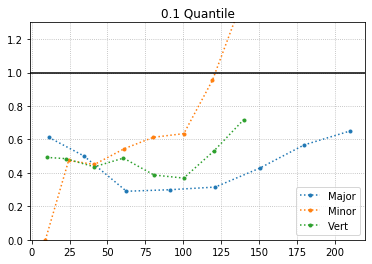

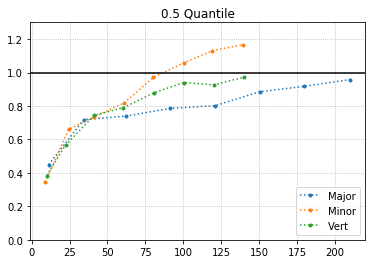

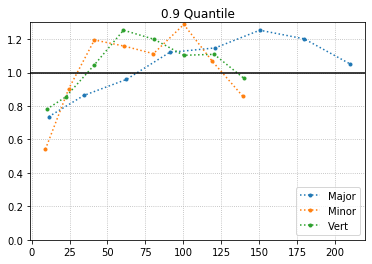

In [251]:
for q in thresholds:

    sill = np.var(icomps[f"{q} Indicator"])

    maj_ivario = update_variogram(icomps[f"{q} Indicator"].values, maj_lag_dict)
    min_ivario = update_variogram(icomps[f"{q} Indicator"].values, min_lag_dict)
    vrt_ivario = update_variogram(icomps[f"{q} Indicator"].values, vrt_lag_dict)

    fig, ax = plt.subplots()
    ax.plot(maj_bins, maj_ivario / sill, ls=":", marker=".", label="Major")
    ax.plot(min_bins, min_ivario / sill, ls=":", marker=".", label="Minor")
    ax.plot(vrt_bins, vrt_ivario / sill, ls=":", marker=".", label="Vert")

    ax.set_ylim(0, 1.3)
    ax.axhline(1.0, c="k")
    ax.set_title(f"{q} Quantile")
    ax.legend(loc=4)

'ivario'

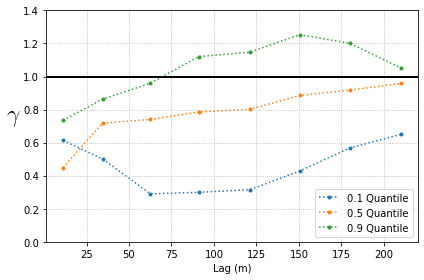

In [252]:
fig, ax = plt.subplots()

for q in thresholds:

    sill = np.var(icomps[f"{q} Indicator"])
    maj_ivario = update_variogram(icomps[f"{q} Indicator"].values, maj_lag_dict)
    ax.plot(
        maj_bins, maj_ivario / sill, ls=":", marker=".", label=f"{q} Quantile"
    )

    ax.set_ylim(0, 1.4)
    ax.axhline(1.0, c="k")
    ax.legend(loc=4)

ax.set_xlabel("Lag (m)")
ax.set_ylabel("$\gamma$", fontsize=24, rotation=0, labelpad=10, usetex=True)
utils.savefig("ivario")

In [253]:
ivmods = {
    quantiles[0]: VariogramModel(
        """2    0                         -nst, nugget effect
    1    0.25  -40   0.0   0.0        -it,cc,ang1,ang2,ang3
    50.0  50.0  50.0        -a_hmax, a_hmin, a_vert
    1    0.75  -40   0.0   0.0        -it,cc,ang1,ang2,ang3
    1500.0  250.0  500.0        -a_hmax, a_hmin, a_vert"""
    ),
    quantiles[1]: VariogramModel(
        """2    0                         -nst, nugget effect
    2    0.5  -40   0.0   0.0        -it,cc,ang1,ang2,ang3
    25.0  25.0  25.0        -a_hmax, a_hmin, a_vert
    2    0.5  -40   0.0   0.0        -it,cc,ang1,ang2,ang3
    350.0  125.0  200.0        -a_hmax, a_hmin, a_vert"""
    ),
    quantiles[2]: VariogramModel(
        """2    0                         -nst, nugget effect
    2    0.8  -40   0.0   0.0        -it,cc,ang1,ang2,ang3
    40.0  25.0  25.0        -a_hmax, a_hmin, a_vert
    2    0.2  -40   0.0   0.0        -it,cc,ang1,ang2,ang3
    60.0  50.0  40.0        -a_hmax, a_hmin, a_vert"""
    ),
}

ivarios = {q: [] for q in thresholds}
for q in thresholds:
    ivarios[q].append(
        ivmods[q]
        .calcpoints(azm[0], dip[0], lagdist=1, nlags=300)["Variogram"]
        .values
    )
    ivarios[q].append(
        ivmods[q]
        .calcpoints(azm[1], dip[1], lagdist=1, nlags=300)["Variogram"]
        .values
    )
    ivarios[q].append(
        ivmods[q]
        .calcpoints(azm[2], dip[2], lagdist=1, nlags=300)["Variogram"]
        .values
    )

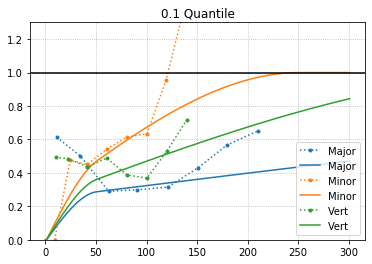

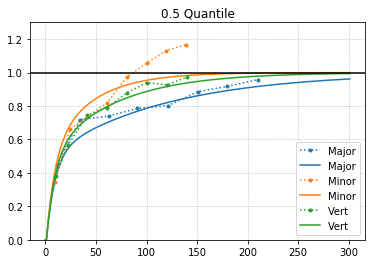

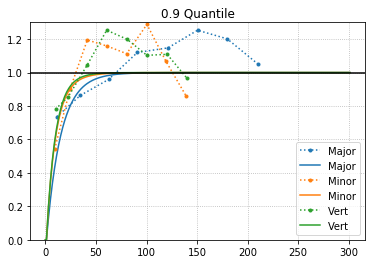

In [254]:
for q in thresholds:

    sill = np.var(icomps[f"{q} Indicator"])

    maj_ivario = update_variogram(icomps[f"{q} Indicator"].values, maj_lag_dict)
    min_ivario = update_variogram(icomps[f"{q} Indicator"].values, min_lag_dict)
    vrt_ivario = update_variogram(icomps[f"{q} Indicator"].values, vrt_lag_dict)

    fig, ax = plt.subplots()
    ax.plot(
        maj_bins, maj_ivario / sill, ls=":", marker=".", c="C0", label="Major"
    )
    ax.plot(ivarios[q][0], c="C0", label="Major")
    ax.plot(
        min_bins, min_ivario / sill, ls=":", marker=".", c="C1", label="Minor"
    )
    ax.plot(ivarios[q][1], c="C1", label="Minor")
    ax.plot(
        vrt_bins, vrt_ivario / sill, ls=":", marker=".", c="C2", label="Vert"
    )
    ax.plot(ivarios[q][2], c="C2", label="Vert")
    ax.set_ylim(0, 1.3)
    ax.axhline(1.0, c="k")
    ax.set_title(f"{q} Quantile")
    ax.legend(loc=4)

# Runs

In [255]:
from sequences_objective import binary_runs, n_pt_conn

runs_above = True
target_runs = {q: [] for q in thresholds}
maxrun = 15

# merge runs from each drillhole into a global histogram
for q, t in thresholds.items():
    temp_runs = np.zeros(maxrun)
    for uid in icomps[dhid].unique():
        dh = icomps.loc[comps[dhid] == uid, f"{q} Indicator"].copy()
        run_freqs = binary_runs(dh.values, runs_above)["cum_runs_freqs"][
            :maxrun
        ]
        temp_runs += np.pad(run_freqs, (0, maxrun - len(run_freqs)))
    target_runs[q] = temp_runs

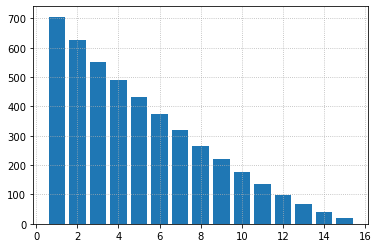

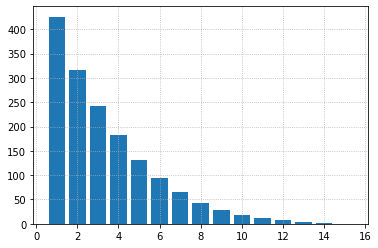

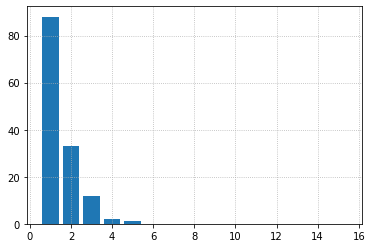

In [256]:
for q in thresholds:
    fig, ax = plt.subplots()
    _ = ax.bar(np.arange(maxrun) + 1, target_runs[q])

# n-Point Connectivity

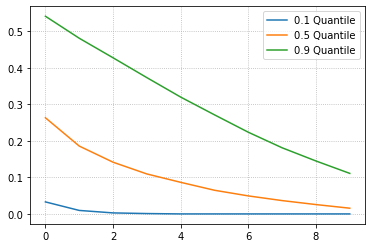

In [257]:
nstep = 10
target_npoint = {}

for j, q in enumerate(thresholds):

    # pad matrix with -1's
    X = np.zeros((maxdhlen, ndh)) - 1

    for i, uid in enumerate(icomps[dhid].unique()):
        X[: dh_lens[i], i] = icomps.loc[
            icomps[dhid] == uid, f"{q} Indicator"
        ].values

    target_npoint[q] = n_pt_conn(X, nstep=nstep)
    plt.plot(target_npoint[q], label=f"{q} Quantile")
    plt.legend()

# Factor Variogram Models

**NEED TO USE ANISOTROPIC MODELS HERE AND INCLUDE AZM AND DIP**

In [258]:
sph_fact = 5
exp_fact = 5
gau_fact = 5
n_fact = sph_fact + exp_fact + gau_fact

# max_range = int(griddef["nx"] * griddef["xsize"] * 0.66)
max_range = int(griddef["ny"] * griddef["ysize"] * 1.0)
min_range = int(griddef["ny"] * griddef["ysize"] * 0.05)

sph_ranges_maj = np.linspace(min_range, max_range, num=sph_fact, endpoint=False)
exp_ranges_maj = np.linspace(min_range, max_range, num=exp_fact, endpoint=False)
gau_ranges_maj = np.linspace(min_range, max_range, num=gau_fact, endpoint=False)

sph_ranges_min = np.linspace(
    min_range, max_range / 2, num=sph_fact, endpoint=False
)
exp_ranges_min = np.linspace(
    min_range, max_range / 2, num=exp_fact, endpoint=False
)
gau_ranges_min = np.linspace(
    min_range, max_range / 2, num=gau_fact, endpoint=False
)

sph_ranges_vrt = np.linspace(
    min_range, max_range / 1.5, num=sph_fact, endpoint=False
)
exp_ranges_vrt = np.linspace(
    min_range, max_range / 1.5, num=exp_fact, endpoint=False
)
gau_ranges_vrt = np.linspace(
    min_range, max_range / 1.5, num=gau_fact, endpoint=False
)

sph_struct = [1] * sph_fact
exp_struct = [2] * exp_fact
gau_struct = [3] * gau_fact

ranges_maj = np.concatenate((sph_ranges_maj, exp_ranges_maj, gau_ranges_maj))
ranges_min = np.concatenate((sph_ranges_min, exp_ranges_min, gau_ranges_min))
ranges_vrt = np.concatenate((sph_ranges_vrt, exp_ranges_vrt, gau_ranges_vrt))

structs = np.concatenate((sph_struct, exp_struct, gau_struct))

In [259]:
# sph_fact = 2
# exp_fact = 7
# gau_fact = 0
# n_fact = sph_fact + exp_fact + gau_fact

# sph_ranges_maj = np.array([50,1500])
# exp_ranges_maj = np.array([50, 175, 1500, 25, 350, 40, 60])
# gau_ranges_maj = []

# sph_ranges_min = np.array([50, 250])
# exp_ranges_min = np.array([100, 125, 125, 25, 125, 25, 50])
# gau_ranges_min = []

# sph_ranges_vrt = np.array([50, 500])
# exp_ranges_vrt = np.array([50, 175, 350, 250, 200, 25, 40])
# gau_ranges_vrt = []

# sph_struct = [1] * sph_fact
# exp_struct = [2] * exp_fact
# gau_struct = [3] * gau_fact

# ranges_maj = np.concatenate((sph_ranges_maj, exp_ranges_maj, gau_ranges_maj))
# ranges_min = np.concatenate((sph_ranges_min, exp_ranges_min, gau_ranges_min))
# ranges_vrt = np.concatenate((sph_ranges_vrt, exp_ranges_vrt, gau_ranges_vrt))

# structs = np.concatenate((sph_struct, exp_struct, gau_struct)).astype(int)

In [260]:
def vario_keys(st):
    if st == 1:
        return "sph"
    elif st == 2:
        return "exp"
    elif st == 3:
        return "gau"


base_vstr = """1    {c0}                         -nst, nugget effect
    {it}    {c1}  {ang1}   {ang2}   {ang3}        -it,cc,ang1,ang2,ang3
    {amax}  {amin}  {avrt}        -a_hmax, a_hmin, a_vert
    """

factor_varios = {}
for i, (st, rmaj, rmin, rvrt) in enumerate(
    zip(structs, ranges_maj, ranges_min, ranges_vrt)
):
    vtype = vario_keys(st)

    if st == 3:  # small nugget to avoid singular matrix with Gaussian model
        factor_varios[f"{vtype}_{i}"] = VariogramModel(
            base_vstr.format(
                it=st,
                c0=0.001,
                c1=0.999,
                ang1=azm[0],
                ang2=azm[1],
                ang3=azm[2],
                amax=rmaj,
                amin=rmin,
                avrt=rvrt,
            )
        )
    else:
        factor_varios[f"{vtype}_{i}"] = VariogramModel(
            base_vstr.format(
                it=st,
                c0=0.0,
                c1=1.0,
                ang1=azm[0],
                ang2=azm[1],
                ang3=azm[2],
                amax=rmaj,
                amin=rmin,
                avrt=rvrt,
            )
        )

In [261]:
for v in factor_varios.values():
    print(v.vargstr)

1    0.0                         -nst, nugget effect
    1    1.0  -40   50   0        -it,cc,ang1,ang2,ang3
    27.0  27.0  27.0        -a_hmax, a_hmin, a_vert
    
1    0.0                         -nst, nugget effect
    1    1.0  -40   50   0        -it,cc,ang1,ang2,ang3
    129.6  75.6  93.6        -a_hmax, a_hmin, a_vert
    
1    0.0                         -nst, nugget effect
    1    1.0  -40   50   0        -it,cc,ang1,ang2,ang3
    232.2  124.2  160.2        -a_hmax, a_hmin, a_vert
    
1    0.0                         -nst, nugget effect
    1    1.0  -40   50   0        -it,cc,ang1,ang2,ang3
    334.79999999999995  172.8  226.79999999999998        -a_hmax, a_hmin, a_vert
    
1    0.0                         -nst, nugget effect
    1    1.0  -40   50   0        -it,cc,ang1,ang2,ang3
    437.4  221.4  293.4        -a_hmax, a_hmin, a_vert
    
1    0.0                         -nst, nugget effect
    2    1.0  -40   50   0        -it,cc,ang1,ang2,ang3
    27.0  27.0  27.0     

# Factor Simulation
- Each initial factor is simulated with a different random number seed and a completely different variogram
- Each initial factor has a single pure structure that reflects something with unique spatial correlation that could translate to something combined with other factors

In [262]:
# coords = comps[["x", "y", "z"]].values
# nxyd = len(coords)
# Ysimd = np.zeros([nxyd, n_fact + 1])
# Ysimd[:, 0] = rng.normal(size=nxyd)  # nugget
# C = []

# for i, (st, rx, ry, rz) in enumerate(
#     zip(structs, ranges_x, ranges_y, ranges_z)
# ):
#     if st < 3:
#         c = sim.pairwisecova_3D(
#             coords,
#             ranges_x=[rx],
#             ranges_y=[ry],
#             ranges_z=[rz],
#             vtypes=[st],
#             c0=0.0,
#             cc=[1.0],
#         )
#     else:  # small nugget to avoid singular matrix with Gaussian model
#         c = sim.pairwisecova_3D(
#             coords,
#             ranges_x=[rx],
#             ranges_y=[ry],
#             ranges_z=[rz],
#             vtypes=[st],
#             c0=0.001,
#             cc=[0.999],
#         )
#     Ysimd[:, i + 1] = sim.lusim(c, nr=1, seed=78451 + i * 1000)
#     C.append(c)

In [263]:
coords = comps[["x", "y", "z"]].values
nxyd = len(coords)
Ysimd = np.zeros([nxyd, n_fact + 1])
Ysimd[:, 0] = rng.normal(size=nxyd)  # nugget

for i, st in enumerate(structs):
    vtype = vario_keys(st)
    cova = factor_varios[f"{vtype}_{i}"].pairwisecova(coords)
    Ysimd[:, i + 1] = sim.lusim(cova, nr=1, seed=78451 + i * 1000)

In [264]:
Ysimd.shape

(746, 16)

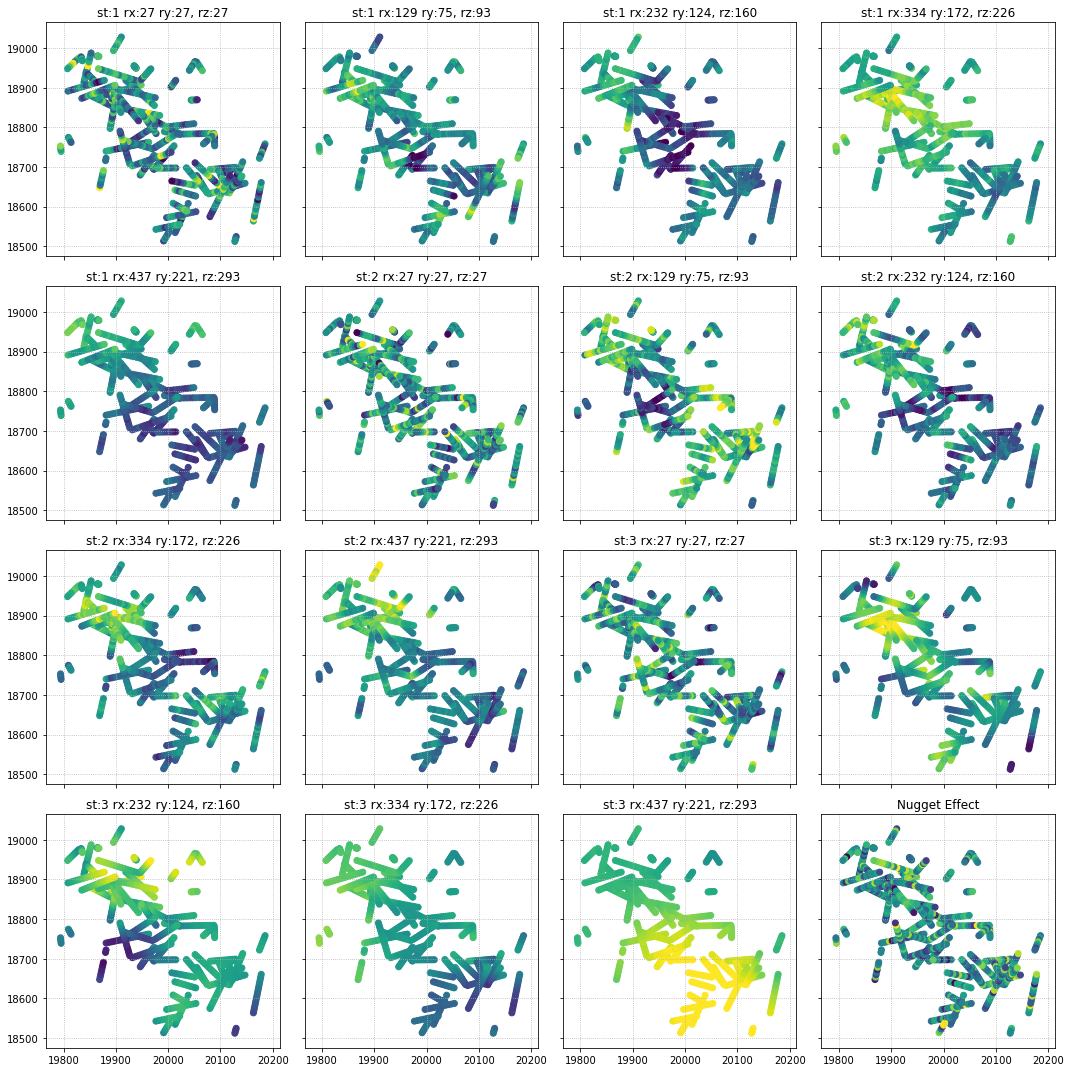

In [265]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex="all", sharey="all")
for i, (ax, st, rx, ry, rz) in enumerate(
    zip(axes.flatten(), structs, ranges_maj, ranges_min, ranges_vrt),
):
    im = ax.scatter(
        coords[:, 0], coords[:, 1], c=Ysimd[:, i + 1], vmin=-2.5, vmax=2.5
    )
    #     plt.colorbar(im, ax=ax)
    ax.set_title(f"st:{int(st)} rx:{int(rx)} ry:{int(ry)}, rz:{int(rz)}")
axes[-1, -1].scatter(
    coords[:, 0], coords[:, 1], c=Ysimd[:, 0], vmin=-2.5, vmax=2.5
)
axes[-1, -1].set_title("Nugget Effect")
fig.tight_layout()

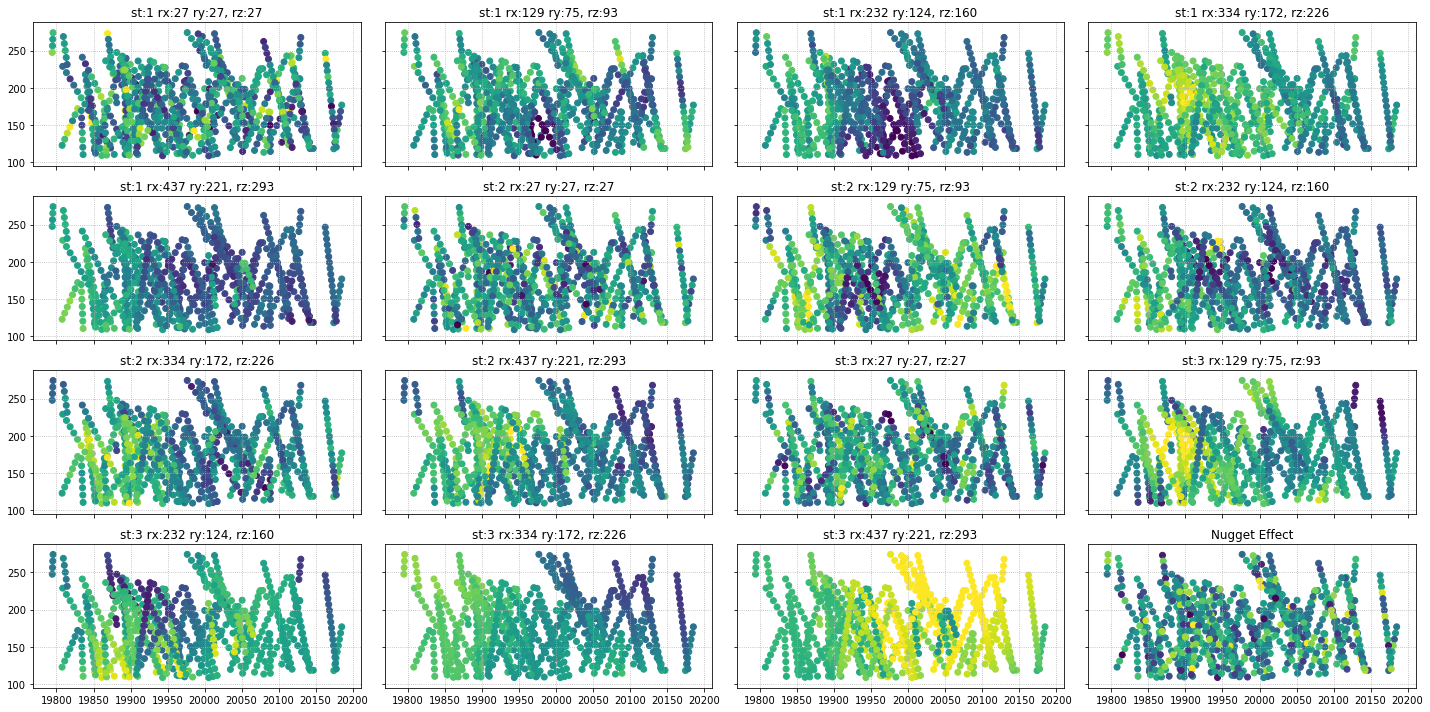

In [266]:
fig, axes = plt.subplots(4, 4, figsize=(20, 10), sharex="all", sharey="all")
for i, (ax, st, rx, ry, rz) in enumerate(
    zip(axes.flatten(), structs, ranges_maj, ranges_min, ranges_vrt),
):
    im = ax.scatter(
        coords[:, 0], coords[:, 2], c=Ysimd[:, i + 1], vmin=-2.5, vmax=2.5
    )
    #     plt.colorbar(im, ax=ax)
    ax.set_title(f"st:{int(st)} rx:{int(rx)} ry:{int(ry)}, rz:{int(rz)}")
axes[-1, -1].scatter(
    coords[:, 0], coords[:, 2], c=Ysimd[:, 0], vmin=-2.5, vmax=2.5
)
axes[-1, -1].set_title("Nugget Effect")
fig.tight_layout()

# Network LMR

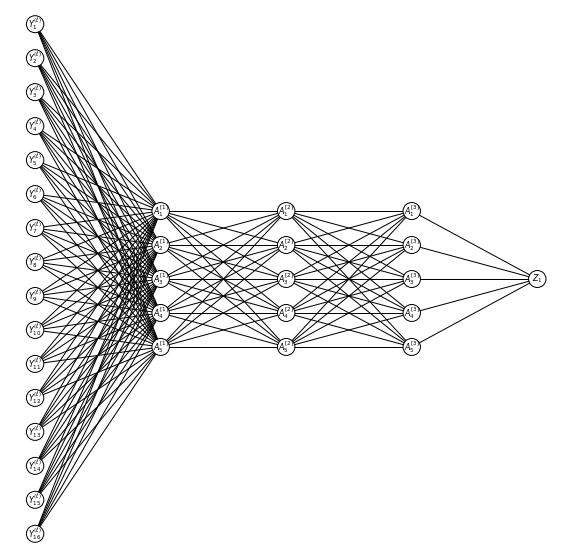

In [267]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")
layer_dims = [n_fact + 1, 5, 5, 5, 1]
# layer_dims = [n_fact + 1, 3, 3, 3, 1]
draw_neural_net(ax, 0.05, 0.95, 0.0, 1.0, layer_dims, "Y", "A", "Z", 8)

In [268]:
parameters = nn.intitialize_layer_params(layer_dims, 5841044, init="uniform")

In [269]:
connections = []
biases = []
for k, v in parameters.items():
    if "W" in k:
        connections.append(v.shape[0] * v.shape[1])
    if "b" in k:
        biases.append(v.shape[0] * v.shape[1])
    print(k, "shape:", v.shape)
tconn = np.sum(connections)
tbias = np.sum(biases)
print("Total connections:", tconn)
print("Total biases:", tbias)

W1 shape: (5, 16)
b1 shape: (5, 1)
W2 shape: (5, 5)
b2 shape: (5, 1)
W3 shape: (5, 5)
b3 shape: (5, 1)
W4 shape: (1, 5)
b4 shape: (1, 1)
Total connections: 135
Total biases: 16


In [270]:
AL = nn.linear_forward(Ysimd, parameters, nn.relu)
AL.shape

(746,)

# Objective Scaling

In [271]:
fobj = Objective(Ysimd)
bounds = fobj.generate_bounds(parameters, connections) + [(0, 1)] * tbias
afunc = nn.sigmoid
maxpert = 1000
seed = 5841044


objscale = fobj.objective_scaling(
    connections,
    biases,
    parameters,
    bounds,
    [maj_lag_dict, min_lag_dict, vrt_lag_dict],
    [maj_bins, min_bins, vrt_bins],
    thresholds,
    runs_above,
    maxrun,
    nstep,
    dhids,
    dh_lens,
    afunc,
    maxpert,
    seed,
    vario=True,
    vario_target=[target_maj, target_min, target_vrt],
    ivario=True,
    ivario_target=ivarios,
    runs=True,
    runs_target=target_runs,
    npoint=True,
    npoint_target=target_npoint,
)

targets = [
    "Continous Variogram",
    "Indicator Variograms",
    "Cumulative Runs",
    "n-Point Connectivity",
]
for name, oscl in zip(targets, objscale):
    print(f"{name} scale factor: {oscl}\n")

Continous Variogram scale factor: 1.2932433252181978

Indicator Variograms scale factor: 0.31146588388465046

Cumulative Runs scale factor: 5.131638086893379e-05

n-Point Connectivity scale factor: 5.3769576444156275



# Minimize Objective 

- If a `PicklingError` occurs here, restart kernel and run all cells. 

In [272]:
maj_bins

[11.25987346006488,
 34.416810340114736,
 62.56047473550351,
 90.99785761540689,
 121.11408939721576,
 150.45973333661067,
 179.75717048749755,
 209.85258862661385]

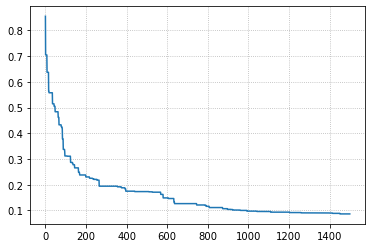

In [297]:
lag_dicts = [maj_lag_dict, min_lag_dict, vrt_lag_dict]
lags = [maj_bins, min_bins, vrt_bins]
target_vario = [target_maj, target_min, target_vrt]
target_ivario = ivarios

vario = True
ivario = True
runs = True
npoint = True

args = (
    parameters,
    connections,
    biases,
    target_vario,
    target_ivario,
    target_runs,
    target_npoint,
    lag_dicts,
    lags,
    maxrun,
    nstep,
    dhids,
    dh_lens,
    runs_above,
    thresholds,
    afunc,
    objscale,
    vario,
    ivario,
    runs,
    npoint,
)

results = pde(
    fobj,
    args,
    bounds=bounds,  # [bounds] * (tconn + tbias),
    popsize=30,  # int(0.5 * (tconn + tbias)),
    its=1500,
    seed=68,
)
plt.plot(results[-1])

In [298]:
# de_params = parameters.copy()
# de_weights = []
# de_biases = []
# num_wts = np.cumsum([0] + connections)
# for ell in range(1, len(parameters) // 2 + 1):
#     shape = de_params["W" + str(ell)].shape
#     de_params["W" + str(ell)] = results[0][
#         num_wts[ell - 1] : num_wts[ell]
#     ].reshape(shape)
#     de_weights.append(de_params["W" + str(ell)])

de_params = nn.vector_to_matrices(parameters, connections, biases, results[0])

edge_wts = []
for k, v in de_params.items():
    if "W" in k:
        edge_wts.append(v)

In [299]:
de_params

{'W1': array([[7.92321874e-02, 1.11607999e-01, 7.92321874e-02, 7.92321874e-02,
         8.52424614e-01, 7.92321874e-02, 9.28414945e-02, 2.65367948e-01,
         8.14460850e-02, 1.38430573e-01, 9.89115001e-01, 7.92321874e-02,
         9.19880454e-01, 7.92321874e-02, 9.81221946e-01, 9.37444854e-01],
        [3.98432380e-01, 4.88862601e-05, 5.87559199e-02, 4.08377995e-01,
         8.33529610e-01, 4.88862601e-05, 7.39511258e-03, 3.00680116e-01,
         8.10336190e-02, 3.83142824e-02, 9.10744148e-01, 4.63510621e-02,
         8.87290257e-01, 4.34797693e-02, 3.97576889e-01, 7.55457490e-01],
        [5.53435876e-02, 5.38786803e-01, 5.52704445e-01, 6.52291650e-01,
         5.95507020e-01, 7.56620887e-02, 3.00277958e-01, 9.54178552e-01,
         4.89418984e-02, 4.80792405e-02, 3.88974613e-01, 9.53982756e-01,
         8.51137795e-01, 1.55225405e-01, 4.80792405e-02, 9.11785806e-01],
        [2.84355030e-01, 2.97543782e-01, 6.67326835e-03, 4.81229950e-03,
         9.00455068e-03, 1.44158412e-03, 3

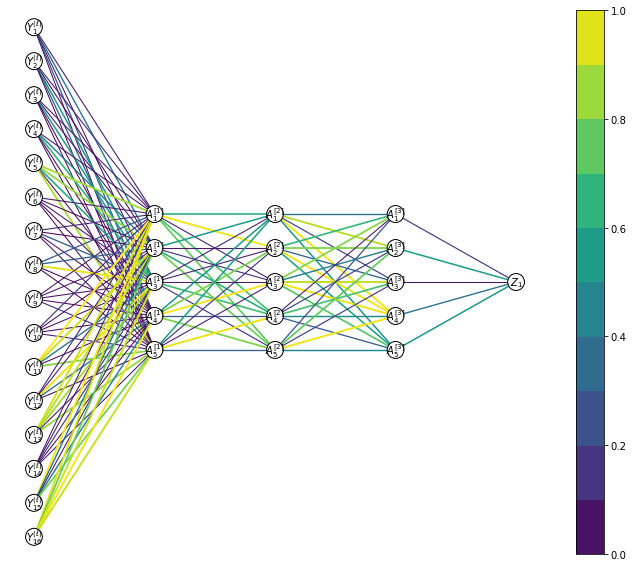

In [300]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("off")
cmap = "viridis"  # "Spectral_r"
draw_weighted_neural_net(
    ax,
    0.05,
    0.95,
    0.0,
    1.0,
    layer_dims,
    "Y",
    "A",
    "Z",
    10,
    node_wts=None,
    edge_wts=edge_wts,
    cmap=cmap,
)
sm, _ = get_rgb(0, cmap, 0, 1)
plt.colorbar(sm, boundaries=np.arange(0, 1.1, 0.1))

In [301]:
out_var = nn.node_variance(Ysimd, de_params, afunc)
out_var

{'W1': array([0.0276655 , 0.04821341, 0.04154957, 0.01179068, 0.04287534]),
 'W2': array([0.00084274, 0.00074367, 0.00071819, 0.00115531, 0.00036324]),
 'W3': array([1.48183776e-05, 3.54118920e-06, 8.70508247e-06, 2.58817327e-06,
        1.16750516e-05]),
 'W4': array([1.90459536e-05])}

# Summarize Results

In [302]:
from variogram_objective import indicator_transform

de_AL = nn.linear_forward(Ysimd, de_params, afunc)
de_AL_i, ivars = indicator_transform(de_AL, thresholds.values())

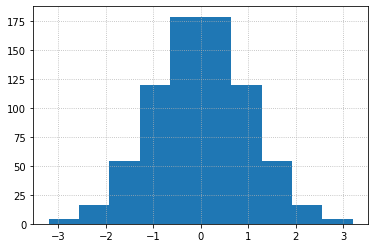

In [303]:
_ = plt.hist(de_AL)

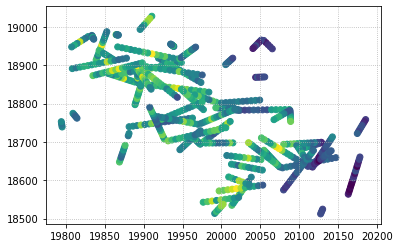

In [304]:
plt.scatter(coords[:, 0], coords[:, 1], c=de_AL, vmin=-2.5, vmax=2.5)

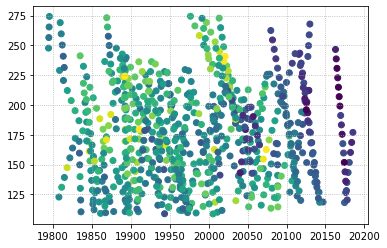

In [305]:
plt.scatter(coords[:, 0], coords[:, 2], c=de_AL, vmin=-2.5, vmax=2.5)

## Variograms

In [306]:
de_maj_vario = update_variogram(de_AL, maj_lag_dict)
de_min_vario = update_variogram(de_AL, min_lag_dict)
de_vrt_vario = update_variogram(de_AL, vrt_lag_dict)

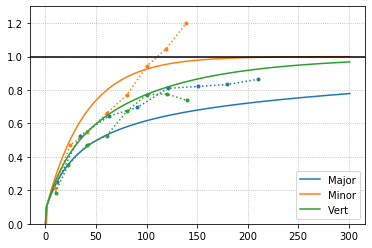

In [307]:
fig, ax = plt.subplots()
ax.plot(maj_bins, de_maj_vario, ls=":", marker=".", c="C0")
ax.plot(target_maj, label="Major")
ax.plot(min_bins, de_min_vario, ls=":", marker=".", c="C1")
ax.plot(target_min, c="C1", label="Minor")
ax.plot(vrt_bins, de_vrt_vario, ls=":", marker=".", c="C2")
ax.plot(target_vrt, c="C2", label="Vert")
ax.set_ylim(0, 1.3)
ax.axhline(1.0, c="k")
ax.legend(loc=4)

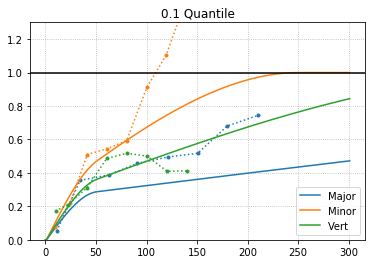

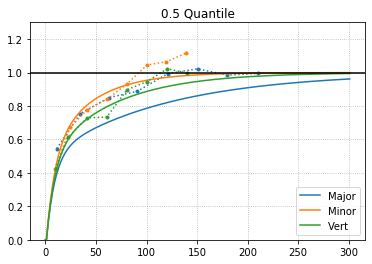

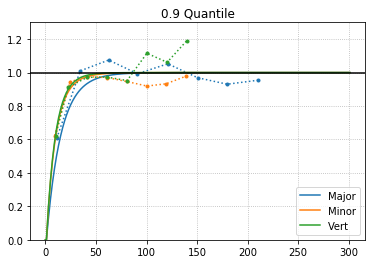

In [308]:
for j, q in enumerate(thresholds):

    sill = np.var(de_AL_i[:, j])

    de_maj_ivario = update_variogram(de_AL_i[:, j], maj_lag_dict)
    de_min_ivario = update_variogram(de_AL_i[:, j], min_lag_dict)
    de_vrt_ivario = update_variogram(de_AL_i[:, j], vrt_lag_dict)

    fig, ax = plt.subplots()
    ax.plot(
        maj_bins, de_maj_ivario / sill, ls=":", marker=".", c="C0",
    )
    ax.plot(ivarios[q][0], c="C0", label="Major")
    ax.plot(
        min_bins, de_min_ivario / sill, ls=":", marker=".", c="C1",
    )
    ax.plot(ivarios[q][1], c="C1", label="Minor")
    ax.plot(vrt_bins, de_vrt_ivario / sill, ls=":", marker=".", c="C2")
    ax.plot(ivarios[q][2], c="C2", label="Vert")
    ax.set_ylim(0, 1.3)
    ax.axhline(1.0, c="k")
    ax.set_title(f"{q} Quantile")
    ax.legend(loc=4)

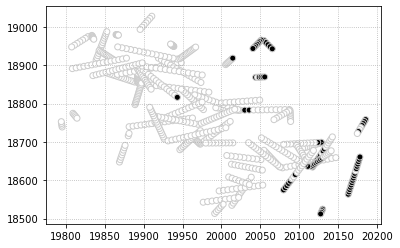

In [309]:
plt.scatter(
    coords[:, 0],
    coords[:, 1],
    c=de_AL_i[:, 0],
    vmin=0,
    vmax=1,
    cmap="binary",
    ec="0.8",
)

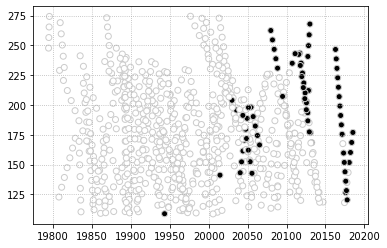

In [310]:
plt.scatter(
    coords[:, 0],
    coords[:, 2],
    c=de_AL_i[:, 0],
    vmin=0,
    vmax=1,
    cmap="binary",
    ec="0.8",
)

 ## Runs

In [311]:
ndh

64

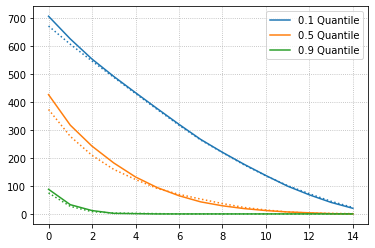

In [312]:
fig, ax = plt.subplots()
for j, q in enumerate(thresholds):
    X = fobj._reshape_vector(de_AL_i[:, j], dhids, dh_lens, -1)
    temp_runs = np.zeros(maxrun)
    for n in range(ndh):
        x = X[:, n]
        x = x[x > -1]
        run_freqs = binary_runs(x, runs_above)["cum_runs_freqs"][:maxrun]
        temp_runs += np.pad(run_freqs, (0, maxrun - len(run_freqs)))
    ax.plot(target_runs[q], c=f"C{j}", label=f"{q} Quantile")
    ax.plot(temp_runs, c=f"C{j}", ls=":")
ax.legend()

## n-Point Connectivity

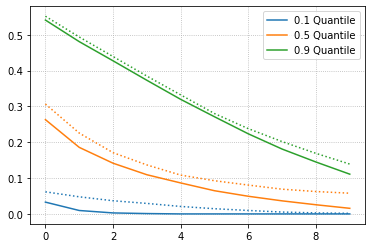

In [313]:
for j, q in enumerate(thresholds):
    X = fobj._reshape_vector(de_AL_i[:, j], dhids, dh_lens, -1)
    npoint = n_pt_conn(X, nstep=nstep)
    plt.plot(target_npoint[q], c=f"C{j}", label=f"{q} Quantile")
    plt.plot(npoint, c=f"C{j}", ls=":")
    plt.legend()

# Simulate and Mix Gridded Factors

- 3D grid is too large for LU simulation

In [314]:
from pygeostat import Program

In [315]:
utils.makedirs(["reals/"])

['reals/']

In [316]:
usgsim = Program("usgsim", getpar=True)

D:\03 UofA\04 Research\02 PhD\Code\Factor Mixing 1D\tmppj3hlno0/usgsim.par has been copied to the clipboard


In [317]:
parstr = """               Parameters for USGSIM
               *********************

START OF MAIN:
1                             -number of realizations to generate, 0=kriging
1                             -number of variables being simulated
0                             -number of rock types to consider
{seed}                         -random number seed
{griddef}
{outfl}                     -file for simulation output
0                             -  output format: (0=reg, 1=coord, 2=binary)
impute.out                    -file for imputed values in case of heterotopic samples
0                             -debugging level: 0,1,2,3
sgsim.dbg                     -file for debugging output 


START OF SRCH:
40                            -number of data to use per variable
300.0   300.0   300.0            -maximum search radii (hmax,hmin,vert)
0.0    0.0    0.0             -angles for search ellipsoid
0                             -sort by distance (0) or covariance (1)
1 1 1                         -if sorting by covariance, indicate variogram rock type, head, tail to use


START OF VARG:
1                             -number of variograms
1  1  1                       -rock type, variable 1, variable 2
{vario}
"""

for i, st in enumerate(structs):
    vtype = vario_keys(st)
    usgsim.run(
        parstr=parstr.format(
            seed=rng.integers(111111, 999999),
            griddef=gridstr,
            outfl=f"./reals/{vtype}_{i}.out",
            vario=factor_varios[f"{vtype}_{i}"].vargstr,
        ),
        liveoutput=False,
    )

Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']
Calling:  ['usgsim', 'temp']


In [318]:
nxyz = griddef["nx"] * griddef["ny"] * griddef["nz"]
Ysim = np.zeros((nxyz, n_fact + 1))
Ysim[:, 0] = rng.normal(size=nxyz)  # nugget

for i, st in enumerate(structs):
    vtype = vario_keys(st)
    Ysim[:, i + 1] = np.loadtxt(f"./reals/{vtype}_{i}.out", skiprows=3)

AL_grid = nn.linear_forward(Ysim, de_params, afunc)

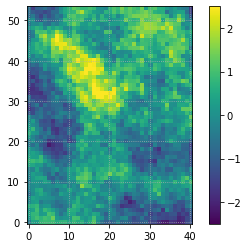

In [319]:
lvl = 9
nx = griddef["nx"]
ny = griddef["ny"]
nxy = nx * ny
plan = AL_grid[lvl * nxy : (lvl + 1) * nxy].reshape(ny, nx)

fig, ax = plt.subplots()
im = ax.imshow(plan, origin="lower", vmin=-2.5, vmax=2.5)
plt.colorbar(im, ax=ax)

In [320]:
griddef

{'nx': 41,
 'ny': 54,
 'nz': 18,
 'xsize': 10,
 'ysize': 10,
 'zsize': 10,
 'xmin': 19794.271,
 'ymin': 18512.2387,
 'zmin': 108.5643}